In [1]:
# default_exp core

# module name here

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
# export
from pathlib import Path
import os
import yaml
import pandas as pd
import requests
import tarfile
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, TypeVar, Union
from typing import Any, AnyStr, Callable, Collection, Dict, Hashable, Iterator, List, Mapping, NewType, Optional
import boto3
import hashlib
import shutil

In [4]:
# export
class Config:
    config_path = Path(os.getenv('SHOTCHART_HOME', '~/.shot_chart')).expanduser()
    config_file = config_path/'config.yml'

    def __init__(self):
        self.config_path.mkdir(parents=True, exist_ok=True)
        if not self.config_file.exists(): self.create_config()
        self.d = self.load_config()

    def __getitem__(self,k):
        k = k.lower()
        if k not in self.d: k = k+'_path'
        if k in ["my_dpi","fig_height","fig_width"]:
            return self.d[k]
        return Path(self.d[k])

    def __getattr__(self,k):
        if k=='d': raise AttributeError
        return self[k]

    def __setitem__(self,k,v): self.d[k] = str(v)
    def __contains__(self,k): return k in self.d

    def load_config(self):
        with open(self.config_file, 'r') as f:
            config = yaml.safe_load(f)
            if 'version' in config and config['version'] == 1: return config
        self.create_config()
        return self.load_config()

    def create_config(self):
        F = plt.gcf()
        # Now check everything with the defaults:
        DPI = F.get_dpi()
        config = {'data_path':    str(self.config_path/'data'),
                  'archive_path':    str(self.config_path/'archive'),
                  'version':      1,
                  'my_dpi': DPI,
                  'fig_height': 472,
                  'fig_width': 500
                 }
        self.save_file(config)

    def save(self): self.save_file(self.d)
    def save_file(self, config):
        with self.config_file.open('w') as f: yaml.dump(config, f, default_flow_style=False)

In [5]:
config = Config()

## URLs -

In [6]:
# export
class URLs():
    "Global constants for dataset and model URLs."
    LOCAL_PATH = Path.cwd()
    S3 = 'https://nba-shot-charts.s3.amazonaws.com/'

    SHOTS_2000    = f'{S3}shots-2000.tgz'
    SHOTS_2001    = f'{S3}shots-2001.tgz'
    SHOTS_2002    = f'{S3}shots-2002.tgz'
    SHOTS_2003    = f'{S3}shots-2003.tgz'
    SHOTS_2004    = f'{S3}shots-2004.tgz'
    SHOTS_2005    = f'{S3}shots-2005.tgz'
    SHOTS_2006    = f'{S3}shots-2006.tgz'
    SHOTS_2007    = f'{S3}shots-2007.tgz'
    SHOTS_2008    = f'{S3}shots-2008.tgz'
    SHOTS_2009    = f'{S3}shots-2009.tgz'
    SHOTS_2010    = f'{S3}shots-2010.tgz'
    SHOTS_2011    = f'{S3}shots-2011.tgz'
    SHOTS_2012    = f'{S3}shots-2012.tgz'
    SHOTS_2013    = f'{S3}shots-2013.tgz'
    SHOTS_2014    = f'{S3}shots-2014.tgz'
    SHOTS_2015    = f'{S3}shots-2015.tgz'
    SHOTS_2016    = f'{S3}shots-2016.tgz'
    SHOTS_2017    = f'{S3}shots-2017.tgz'
    SHOTS_2018    = f'{S3}shots-2018.tgz'
    SHOTS_2019    = f'{S3}shots-2019.tgz'

    def path(url, c_key='archive'):
        fname = url.split('/')[-1]
        local_path = URLs.LOCAL_PATH/('models' if c_key=='models' else 'archive')/fname
        if local_path.exists(): return local_path
        return Config()[c_key]/fname

## Downloading

In [7]:
# export
def download_url(url, dest, overwrite=False, pbar=None, show_progress=True, chunk_size=1024*1024,
                 timeout=4, retries=5):
    "Download `url` to `dest` unless it exists and not `overwrite`"
    if os.path.exists(dest) and not overwrite: return

    s = requests.Session()
    s.mount('http://',requests.adapters.HTTPAdapter(max_retries=retries))
    # additional line to identify as a firefox browser, see fastai/#2438
    s.headers.update({'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'})
    u = s.get(url, stream=True, timeout=timeout)
    try: file_size = int(u.headers["Content-Length"])
    except: show_progress = False

    with open(dest, 'wb') as f:
        nbytes = 0
        if show_progress: pbar = progress_bar(range(file_size), leave=False, parent=pbar)
        try:
            if show_progress: pbar.update(0)
            for chunk in u.iter_content(chunk_size=chunk_size):
                nbytes += len(chunk)
                if show_progress: pbar.update(nbytes)
                f.write(chunk)
        except requests.exceptions.ConnectionError as e:
            fname = url.split('/')[-1]
            data_dir = dest.parent
            print(f'\n Download of {url} has failed after {retries} retries\n'
                  f' Fix the download manually:\n'
                  f'$ mkdir -p {data_dir}\n'
                  f'$ cd {data_dir}\n'
                  f'$ wget -c {url}\n'
                  f'$ tar xf {fname}\n'
                  f' And re-run your code once the download is successful\n')

In [8]:
# export
def download_data(url, fname=None, c_key='archive', force_download=False):
    "Download `url` to `fname`."
    fname = Path(fname or URLs.path(url, c_key=c_key))
    fname.parent.mkdir(parents=True, exist_ok=True)
    if not fname.exists() or force_download: download_url(url, fname, overwrite=force_download)
    return fname

### Extract

In [9]:
#export
def file_extract(fname, dest='.'):
    "Extract `fname` to `dest` using `tarfile` or `zipfile"
    fname = str(fname)
    if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)
    elif fname.endswith('zip'): zipfile.ZipFile(fname     ).extractall(dest)
    else: raise Exception(f'Unrecognized archive: {fname}')

`file_extract` is used by default in `untar_data` to decompress the downloaded file.

In [10]:
#export 
def _get_check(url):
    s3 = boto3.client('s3')
    s3_resp = s3.head_object(Bucket=URLs.S3.split(".")[0].split("//")[1],Key=url.split("/")[-1])
    ETag = s3_resp['ETag'].strip('"')
    # Open,close, read file and calculate MD5 on its contents 
    with open(Path(URLs.path(url)),"rb") as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        md5_returned = hashlib.md5(data).hexdigest()
    return ETag != md5_returned

In [11]:
_get_check(URLs.SHOTS_2019)

False

In [12]:
#export
def untar_data(url, fname=None, dest=None, c_key='archive', force_download=False, extract_func=file_extract):
    "Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`."
    default_dest = URLs.path(url, c_key=c_key).with_suffix('.csv')
    dest = default_dest if dest is None else Path(dest)/default_dest.name
    fname = Path(fname or URLs.path(url))
#     if fname.exists() and _get_check(url) and _check_file(fname) != _get_check(url):
#         print("A new version of this dataset is available, downloading...")
#         force_download = True
    if fname.exists() and _get_check(url):
        print("A new version of this dataset is available, downloading...")
        force_download = True
    if force_download:
        if fname.exists(): os.remove(fname)
        if dest.exists(): shutil.rmtree(dest)
    if not dest.exists():
        fname = download_data(url, fname=fname, c_key=c_key)
#         if _get_check(url) and _check_file(fname) != _get_check(url):
#             print(f"File downloaded is broken. Remove {fname} and try again.")
        extract_func(fname, dest.parent)
    return dest

In [13]:
#export
def make_df(path):
    "Creates a pandas df from `path`"
    return pd.read_csv(path)

In [14]:
shots_2019 = make_df(untar_data(URLs.SHOTS_2019))

In [15]:
shots_2019.head(50)

,Unnamed: 0,game_id,year,month,day,winner,loser,x,y,play,time_remaining,quarter,shots_by,outcome,attempt,distance,team,winner_score,loser_score
0,0,201910220TOR,2019,10,22,Toronto,New Orleans,147px,242px,"1st quarter, 11:48.0 remaining<br>Lonzo Ball m...",11:48.0,1,Lonzo Ball,missed,2-pointer,11ft,New Orleans,0,0
1,1,201910220TOR,2019,10,22,Toronto,New Orleans,27px,240px,"1st quarter, 11:47.0 remaining<br>Derrick Favo...",11:47.0,1,Derrick Favors,made,2-pointer,1ft,New Orleans,0,2
2,102,201910220TOR,2019,10,22,Toronto,New Orleans,60px,256px,"1st quarter, 11:29.0 remaining<br>OG Anunoby m...",11:29.0,1,OG Anunoby,missed,2-pointer,3ft,Toronto,0,2
3,2,201910220TOR,2019,10,22,Toronto,New Orleans,32px,320px,"1st quarter, 11:16.0 remaining<br>Jrue Holiday...",11:16.0,1,Jrue Holiday,missed,2-pointer,8ft,New Orleans,0,2
4,103,201910220TOR,2019,10,22,Toronto,New Orleans,208px,418px,"1st quarter, 11:11.0 remaining<br>Kyle Lowry m...",11:11.0,1,Kyle Lowry,missed,3-pointer,25ft,Toronto,0,2
5,3,201910220TOR,2019,10,22,Toronto,New Orleans,152px,258px,"1st quarter, 11:00.0 remaining<br>Derrick Favo...",11:00.0,1,Derrick Favors,missed,2-pointer,12ft,New Orleans,0,2
6,4,201910220TOR,2019,10,22,Toronto,New Orleans,133px,366px,"1st quarter, 10:37.0 remaining<br>Brandon Ingr...",10:37.0,1,Brandon Ingram,made,2-pointer,16ft,New Orleans,1,4
7,104,201910220TOR,2019,10,22,Toronto,New Orleans,279px,246px,"1st quarter, 10:17.0 remaining<br>OG Anunoby m...",10:17.0,1,OG Anunoby,made,3-pointer,25ft,Toronto,4,4
8,5,201910220TOR,2019,10,22,Toronto,New Orleans,164px,31px,"1st quarter, 10:11.0 remaining<br>Lonzo Ball m...",10:11.0,1,Lonzo Ball,made,3-pointer,25ft,New Orleans,4,7
9,6,201910220TOR,2019,10,22,Toronto,New Orleans,291px,244px,"1st quarter, 9:55.0 remaining<br>Jrue Holiday ...",9:55.0,1,Jrue Holiday,missed,3-pointer,26ft,New Orleans,4,7


## List teams

In [16]:
#export
def list_teams(df):
    "Lists all the teams that play in one season"
    return df['team'].drop_duplicates()

In [17]:
print(list_teams(shots_2019))

0        New Orleans
2            Toronto
203        LA Lakers
204      LA Clippers
369          Atlanta
370            Miami
524           Denver
689      San Antonio
1030         Memphis
1210      Sacramento
1212        Portland
1382         Detroit
1383        Brooklyn
1735      Washington
1736       Minnesota
1924         Orlando
2283            Utah
2284        Oklahoma
2666         Phoenix
2849        New York
3026          Boston
3027    Philadelphia
3200       Cleveland
4052         Chicago
4053         Indiana
4222          Dallas
4413       Charlotte
5972       Milwaukee
6357         Houston
6359    Golden State
Name: team, dtype: object


## List unique game ids

In [18]:
#export
def list_game_ids(df,year,month,day):
    "Lists unique game ids for a given date"
    return df.loc[(df['year']==year) & (df['month']==month) & (df['day']==day)]['game_id'].drop_duplicates()
    

In [19]:
list_game_ids(shots_2019,2019,11,25)

39020    201911250ATL
39372    201911250TOR
39543    201911250SAS
39720    201911250MIL
39902    201911250MIA
40066    201911250IND
40257    201911250GSW
40430    201911250DET
40593    201911250CLE
40781    201911250CHI
40955    201911250BOS
Name: game_id, dtype: object

## Field goal percentages

In [20]:
#export
def _calculate_fg_pct(fgm,fga):
    return fgm/fga*100

In [21]:
#export
def _calculate_efg_pct(fgm,three_pm,fga):
    return ((fgm + 0.5 * three_pm)/fga)*100

In [22]:
#export
def _calculate_avg_fga(df):
    #len(df) -> all shots taken for the season
    #len(df['shots_by']).drop_duplicates() -> number of different players who have taken shots for the season
    # len(df)/len(df['shots_by']).drop_duplicates() -> AVG_FGA
    number_of_games = len(df['game_id'].drop_duplicates())
    players_more_than_one_shot = []
    for x in df['shots_by'].drop_duplicates().to_list():
        if len(df.loc[df['shots_by'] == x]) >= number_of_games:
            players_more_than_one_shot.append(x)
    return len(df.loc[df["shots_by"].isin(players_more_than_one_shot)])/len(players_more_than_one_shot)


In [23]:
#export
def _calculate_avg_efg(df):
    #len(df) -> all shots taken for the season
    number_of_games = len(df['game_id'].drop_duplicates())
    players_more_than_one_shot = []
    for x in df['shots_by'].drop_duplicates().to_list():
        if len(df.loc[df['shots_by'] == x]) >= number_of_games:
            players_more_than_one_shot.append(x)
    reduced_df = df.loc[df["shots_by"].isin(players_more_than_one_shot)]
    fgm = len(reduced_df.loc[reduced_df["outcome"]=="made"])
    three_pm = len(reduced_df.loc[(reduced_df["outcome"]=="made") & (reduced_df["attempt"] == "3-pointer")])
    fga = len(reduced_df)
    return ((fgm + 0.5 * three_pm)/fga)*100
        

## Team plots given a date range

In [24]:
#export
Y_MODIFIER = 466
X_MODIFIER = 8

In [25]:
#export
def plot_team(df:pd.DataFrame, team:str,date_range:Union[str,tuple,int]="all",made:bool=True,missed:bool=True,attempt:str="all", distance:Union[str,List[str]]="all"):
    "Plots the shot chart for `team` given a `date_range`"
    plt.figure(figsize=(2 * Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    plt.subplot(1, 2, 1)
    plt.title(team+ " shot chart")
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    if date_range == "all":
        shots_df = df.loc[(df["team"]==team)]
    elif type(date_range) == int:
        #means month
        shots_df = df.loc[(df["team"]==team) & (df["month"]==date_range)]
    else:
        #custom date range in the form of ((from_y,from_m,from_d),(to_y,to_m,to_d))
        from_index = df[(df["year"]==date_range[0][0]) & (df["month"]==date_range[0][1]) & (df["day"]==date_range[0][2])].index[0]
        to_index = df[(df["year"]==date_range[1][0]) & (df["month"]==date_range[1][1]) & (df["day"]==date_range[1][2])].index[0]
        shots_df = df.iloc[[from_index,to_index]]
    if attempt == "2-pointer":
        if distance == "all":
            shots_df = shots_df.loc[(shots_df["team"]==team) & (shots_df["attempt"]=="2-pointer")]
        else:
            shots_df = shots_df.loc[(shots_df["team"]==team) & (shots_df["attempt"]=="2-pointer") & (shots_df["distance"].isin(distance))]
    elif attempt == "3-pointer":
        if distance == "all":
            shots_df = shots_df.loc[(shots_df["team"]==team) & (shots_df["attempt"]=="3-pointer")]
        else:
            shots_df = shots_df.loc[(shots_df["team"]==team) & (shots_df["attempt"]=="2-pointer") & (shots_df["distance"].isin(distance))]
    else:
        if distance == "all":
            shots_df = shots_df.loc[(shots_df["team"]==team)]
        else:
            shots_df = shots_df.loc[(shots_df["team"]==team) & (shots_df["distance"].isin(distance))]
    #misses vs made
    if made:
        mades_df = shots_df.loc[shots_df['outcome']=='made']
        ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys)
    if missed:
        misses_df = shots_df.loc[shots_df['outcome']=='missed']
        ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys,marker="x")
    ax = plt.subplot(1, 2, 2)
    plt.title(team+ " shot distribution")
    distances = shots_df['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
    plt.hist(distances,bins = 30)
    fg_pct = round(_calculate_fg_pct(len(mades_df),len(shots_df)),2)
    efg_pct = round(_calculate_efg_pct(len(mades_df),len(mades_df[mades_df["attempt"]=="3-pointer"]),len(shots_df)),2)
    ax.text(45, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()
    

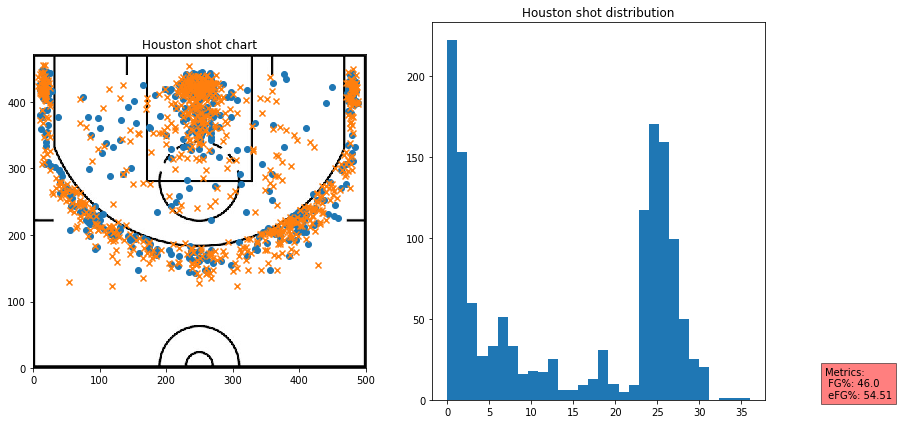

In [26]:
plot_team(shots_2019,"Houston",date_range=12)

In [27]:
print(list_teams(shots_2019))

0        New Orleans
2            Toronto
203        LA Lakers
204      LA Clippers
369          Atlanta
370            Miami
524           Denver
689      San Antonio
1030         Memphis
1210      Sacramento
1212        Portland
1382         Detroit
1383        Brooklyn
1735      Washington
1736       Minnesota
1924         Orlando
2283            Utah
2284        Oklahoma
2666         Phoenix
2849        New York
3026          Boston
3027    Philadelphia
3200       Cleveland
4052         Chicago
4053         Indiana
4222          Dallas
4413       Charlotte
5972       Milwaukee
6357         Houston
6359    Golden State
Name: team, dtype: object


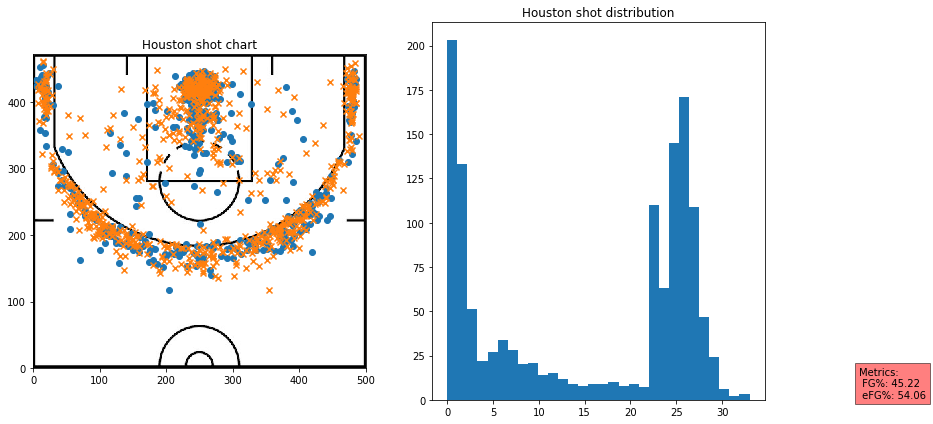

In [28]:
plot_team(shots_2019,"Houston",date_range=11)

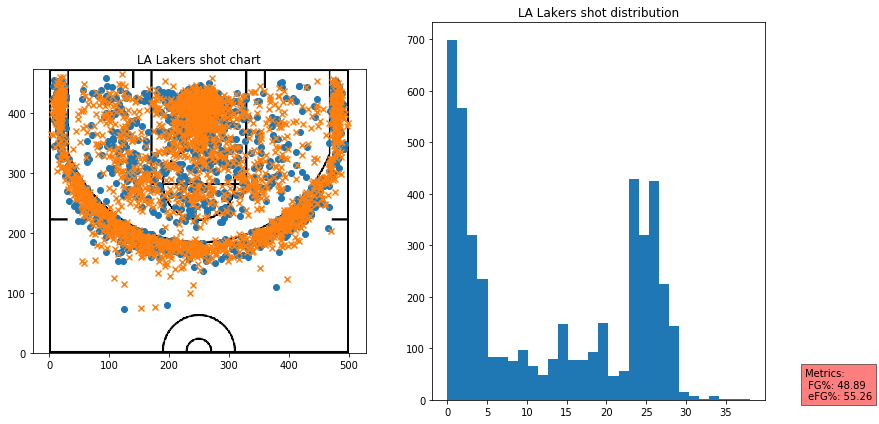

In [29]:
plot_team(shots_2019,"LA Lakers")

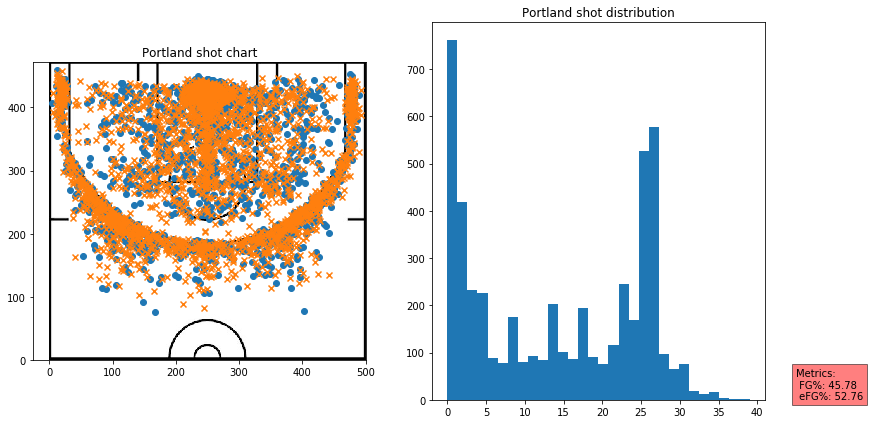

In [30]:
plot_team(shots_2019,"Portland")

## Plot winner shot chart

In [31]:
#export
def plot_winner(df:pd.DataFrame, game_id:str,made:bool=True,missed:bool=True,attempt:str="all", distance:Union[str,List[str]]="all"):
    "Plots the shot chart for the winner team of `game_id`"
    plt.figure(figsize=(2 * Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    #find winner first
    winner = df.loc[df["game_id"]==game_id].iloc[0]["winner"]
    plt.subplot(1, 2, 1)
    plt.title(winner+ " shot chart")
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    if attempt == "2-pointer":
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["attempt"]=="2-pointer")]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["attempt"]=="2-pointer") & (df["distance"].isin(distance))]
    elif attempt == "3-pointer":
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["attempt"]=="3-pointer")]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["attempt"]=="2-pointer") & (df["distance"].isin(distance))]
    else:
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner)]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["distance"].isin(distance))]
    #misses vs made
    if made:
        mades_df = shots_df.loc[shots_df['outcome']=='made']
        ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys)
    if missed:
        misses_df = shots_df.loc[shots_df['outcome']=='missed']
        ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys,marker="x")
    ax = plt.subplot(1, 2, 2)
    plt.title(winner+ " shot distribution")
    distances = shots_df['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
    plt.hist(distances,bins = 30)
    fg_pct = round(_calculate_fg_pct(len(mades_df),len(shots_df)),2)
    efg_pct = round(_calculate_efg_pct(len(mades_df),len(mades_df[mades_df["attempt"]=="3-pointer"]),len(shots_df)),2)
    ax.text(42, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

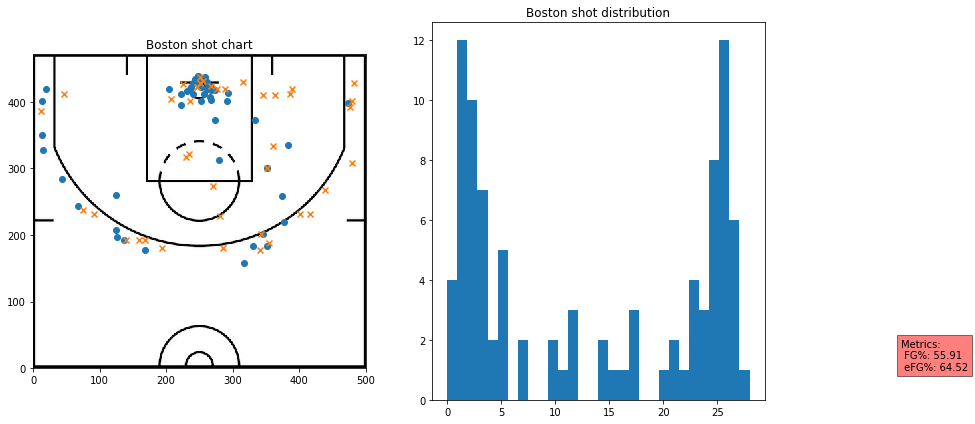

In [32]:
plot_winner(shots_2019,"202001200BOS")

In [33]:
#export
def plot_loser(df:pd.DataFrame, game_id:str,made:bool=True,missed:bool=True,attempt:str="all", distance:Union[str,List[str]]="all"):
    "Plots the shot chart for the loser team of `game_id`"
    plt.figure(figsize=(2 * Config().fig_height/Config().my_dpi,Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    #find loser first
    loser = df.loc[df["game_id"]==game_id].iloc[0]["loser"]
    plt.subplot(1, 2, 1)
    plt.title(loser+ " shot chart")
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    if attempt == "2-pointer":
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser) & (df["attempt"]=="2-pointer")]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser) & (df["attempt"]=="2-pointer") & (df["distance"].isin(distance))]
    elif attempt == "3-pointer":
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser) & (df["attempt"]=="3-pointer")]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser) & (df["attempt"]=="2-pointer") & (df["distance"].isin(distance))]
    else:
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser)]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser) & (df["distance"].isin(distance))]
    #misses vs made
    if made:
        mades_df = shots_df.loc[shots_df['outcome']=='made']
        ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys)
    if missed:
        misses_df = shots_df.loc[shots_df['outcome']=='missed']
        ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys,marker="x")
    ax = plt.subplot(1, 2, 2)
    plt.title(loser+ " shot distribution")
    distances = shots_df['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
    plt.hist(distances,bins = 30)
    fg_pct = round(_calculate_fg_pct(len(mades_df),len(shots_df)),2)
    efg_pct = round(_calculate_efg_pct(len(mades_df),len(mades_df[mades_df["attempt"]=="3-pointer"]),len(shots_df)),2)
    ax.text(35, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

In [34]:
list_game_ids(shots_2019, 2020, 1,20)

110678    202001200ATL
111205    202001200WAS
111375    202001200UTA
111554    202001200POR
111769    202001200MIN
111950    202001200MIL
112120    202001200PHO
112287    202001200MIA
112476    202001200HOU
112835    202001200MEM
113200    202001200CLE
113379    202001200BRK
113714    202001200CHO
113882    202001200BOS
Name: game_id, dtype: object

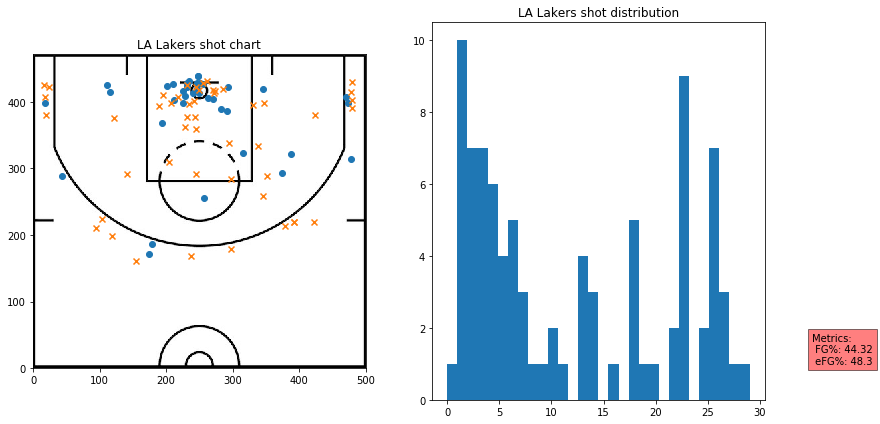

In [35]:
plot_loser(shots_2019,"202001200BOS")

## List players who took shots for a team

In [36]:
#export
def list_team_players(df, team):
    return df.loc[df['team']==team].groupby('shots_by').shots_by.count().reset_index(name='count').sort_values(['count'], ascending=False)

In [37]:
list_team_players(shots_2019,'LA Lakers')

,shots_by,count
9,LeBron James,968
1,Anthony Davis,799
8,Kyle Kuzma,460
3,Danny Green,375
7,Kentavious Caldwell-Pope,373
2,Avery Bradley,288
11,Rajon Rondo,271
5,JaVale McGee,243
4,Dwight Howard,223
0,Alex Caruso,216


## Plot shot chart - player - full season

In [38]:
#export
def plot_player(df:pd.DataFrame, player:str, date_range:Union[str,tuple,int]="all",made:bool=True,missed:bool=True,attempt:str="all",distance:Union[str,list]="all"):
    "Plots shot chart of `player` for the full season"
    plt.figure(figsize=(2*Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    plt.subplot(1, 2, 1)
    plt.title(player+ " shot chart")
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    if date_range == "all":
        player_df = df.loc[(df["shots_by"]==player)]
    elif type(date_range) == int:
        #means month
        player_df = df.loc[(df["shots_by"]==player) & (df["month"]==date_range)]
    else:
        #custom date range in the form of ((from_y,from_m,from_d),(to_y,to_m,to_d))
        from_index = df[(df["year"]==date_range[0][0]) & (df["month"]==date_range[0][1]) & (df["day"]==date_range[0][2])].index[0]
        to_index = df[(df["year"]==date_range[1][0]) & (df["month"]==date_range[1][1]) & (df["day"]==date_range[1][2])].index[0]
        player_df = df.iloc[[from_index,to_index]]
    if attempt == "2-pointer":
        if distance == "all":
            player_df = player_df.loc[(df['shots_by']==player) & (player_df['attempt']=="2-pointer")]
        else:
            player_df = player_df.loc[(df['shots_by']==player) & (player_df['attempt']=="2-pointer") & (player_df["distance"].isin(distance))]
    elif attempt == "3-pointer":
        if distance == "all":
            player_df = player_df.loc[(player_df['shots_by']==player) & (player_df['attempt']=="3-pointer")]
        else:
            player_df = player_df.loc[(df['shots_by']==player) & (player_df['attempt']=="3-pointer") & (player_df["distance"].isin(distance))]
    else:
        if distance == "all":
            player_df = player_df.loc[(df['shots_by']==player)]
        else:    
            player_df = player_df.loc[(df['shots_by']==player) & (player_df["distance"].isin(distance))]
    if made:
        mades_df = player_df.loc[player_df['outcome']=='made']
        ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys,color="g")
#         ax = plt.subplot(1, 2, 2)
#         plt.title(player+ " shot distribution")
#         distances = player_df['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
#         plt.hist(distances,bins = 30)
        fg_pct = round(_calculate_fg_pct(len(mades_df),len(player_df)),2)
        efg_pct = round(_calculate_efg_pct(len(mades_df),len(mades_df[mades_df["attempt"]=="3-pointer"]),len(player_df)),2)
#         ax.text(45, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
    if missed:
        misses_df = player_df.loc[player_df['outcome']=='missed']
        ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys,marker="x",color="r")
    if made:
        ax = plt.subplot(1, 2, 2)
        plt.title(player+ " shot distribution")
        distances = player_df['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
        if type(distance) == list:
            plt.hist(distances,bins = len(distance))
            ax.text(len(distance) + 13, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
        else:
            plt.hist(distances,bins = max(distances))
            ax.text(30 + 12, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

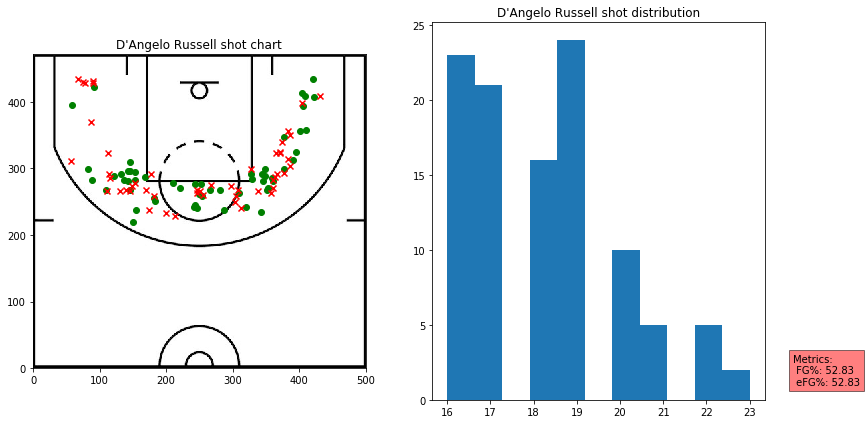

In [39]:
plot_player(shots_2019,"D'Angelo Russell",distance=["16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft"],attempt="2-pointer")

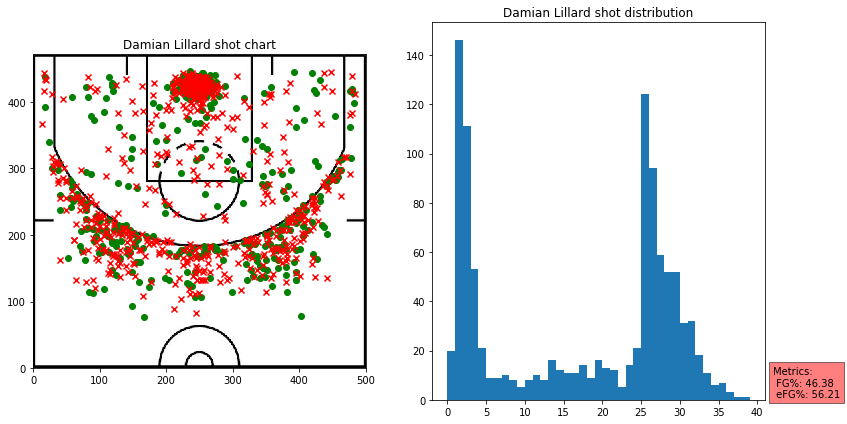

In [40]:
plot_player(shots_2019,"Damian Lillard")

## Finding out the least effective shot of 2019

In [41]:
shots_2019 = make_df(untar_data(URLs.SHOTS_2019))

In [42]:
#export
def least_effective_shot_team(df,team:str,metric:str="efg"):
    distances = ["0ft","1ft","2ft","3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft","29ft","30ft"]
    max_fg = 101
    max_efg = 101
    final_distance = ""
    for distance in distances:
        team_df = df.loc[(df["team"]==team) & (df["distance"]==distance)]
        fg_pct = _calculate_fg_pct(len(team_df[team_df["outcome"]=="made"]),len(team_df))
        efg_pct = _calculate_efg_pct(len(team_df[team_df["outcome"]=="made"]),len(team_df[(team_df["outcome"]=="made") & (team_df["attempt"]=="3-pointer")]),len(team_df))
        if metric == "fg":
            if fg_pct < max_fg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
        else:
            if efg_pct < max_efg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
    team_df = df.loc[(df["team"]==team) & (df["distance"]==final_distance)]
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    plt.figure(figsize=(Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    implot = plt.imshow(img, extent=[0,500,0,472])
    plt.text(600, 100, "Distance:\n "+ final_distance+"\n\nMetrics:\n FG%: "+str(round(max_fg,2))+"\n eFG%: "+str(round(max_efg,2)), bbox=dict(facecolor='red', alpha=0.5))
    mades_df = team_df.loc[team_df['outcome']=='made']
    ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys)
    misses_df = team_df.loc[team_df['outcome']=='missed']
    ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys,marker="x")
    plt.show()

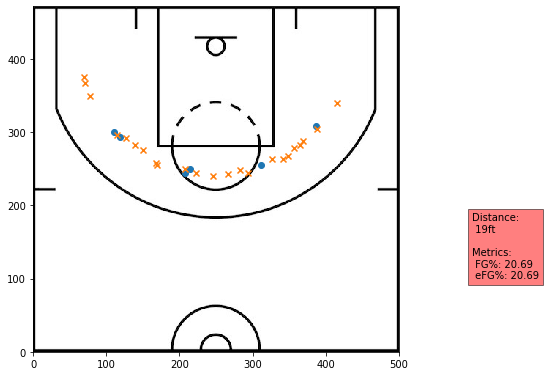

In [43]:
least_effective_shot_team(shots_2019,"Houston",metric="efg")

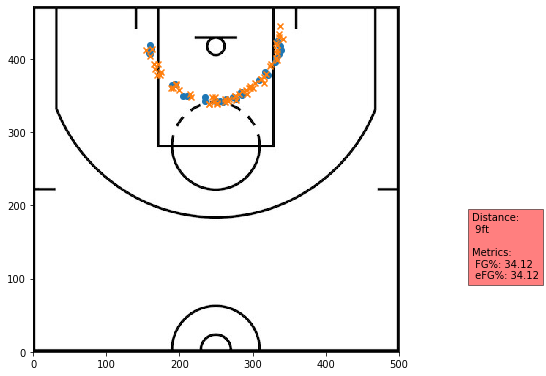

In [44]:
least_effective_shot_team(shots_2019,"Portland")

In [45]:
#export
def least_effective_shot_league(df,metric:str="efg"):
    distances = ["0ft","1ft","2ft","3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft","29ft","30ft"]
    max_fg = 101
    max_efg = 101
    final_distance = ""
    for distance in distances:
        team_df = df.loc[(df["distance"]==distance)]
        fg_pct = _calculate_fg_pct(len(team_df[team_df["outcome"]=="made"]),len(team_df))
        efg_pct = _calculate_efg_pct(len(team_df[team_df["outcome"]=="made"]),len(team_df[(team_df["outcome"]=="made") & (team_df["attempt"]=="3-pointer")]),len(team_df))
        if metric == "fg":
            if fg_pct < max_fg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
        else:
            if efg_pct < max_efg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
    team_df = df.loc[(df["distance"]==final_distance)]
    plt.figure(figsize=(Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    plt.text(600, 100, "Distance:\n "+ final_distance+"\n\nMetrics:\n FG%: "+str(round(max_fg,2))+"\n eFG%: "+str(round(max_efg,2)), bbox=dict(facecolor='red', alpha=0.5))
    mades_df = team_df.loc[team_df['outcome']=='made']
    ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys)
    misses_df = team_df.loc[team_df['outcome']=='missed']
    ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys,marker="x")
    plt.show()

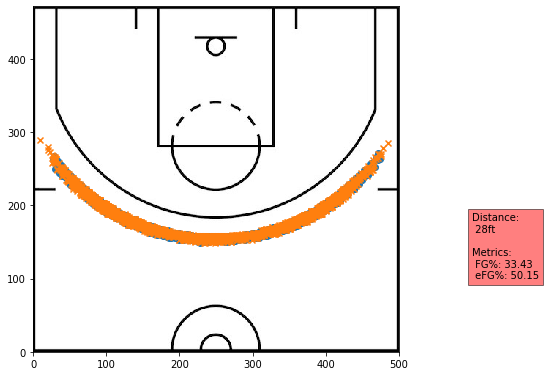

In [46]:
least_effective_shot_league(shots_2019,metric="fg")

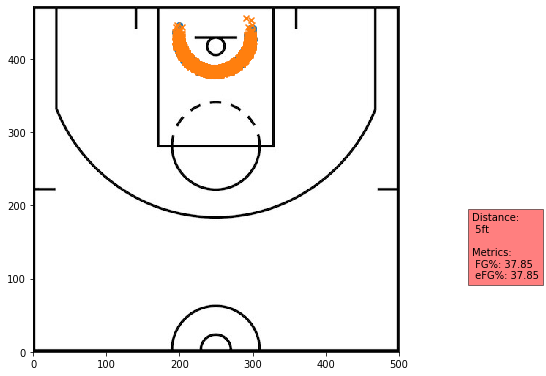

In [47]:
least_effective_shot_league(shots_2019,metric="efg")

In [48]:
#export
def most_effective_shot_league(df,metric:str="efg"):
    distances = ["3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft","29ft","30ft"]
    max_fg = -1
    max_efg = -1
    final_distance = ""
    for distance in distances:
        team_df = df.loc[(df["distance"]==distance)]
        fg_pct = _calculate_fg_pct(len(team_df[team_df["outcome"]=="made"]),len(team_df))
        efg_pct = _calculate_efg_pct(len(team_df[team_df["outcome"]=="made"]),len(team_df[(team_df["outcome"]=="made") & (team_df["attempt"]=="3-pointer")]),len(team_df))
        if metric == "fg":
            if fg_pct > max_fg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
        else:
            if efg_pct > max_efg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
    team_df = df.loc[(df["distance"]==final_distance)]
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    plt.figure(figsize=(Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    implot = plt.imshow(img, extent=[0,500,0,472])
    plt.text(600, 100, "Distance:\n "+ final_distance+"\n\nMetrics:\n FG%: "+str(round(max_fg,2))+"\n eFG%: "+str(round(max_efg,2)), bbox=dict(facecolor='red', alpha=0.5))
    mades_df = team_df.loc[team_df['outcome']=='made']
    ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys)
    misses_df = team_df.loc[team_df['outcome']=='missed']
    ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER- int(x) for x in ys]
    xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys,marker="x")
    plt.show()

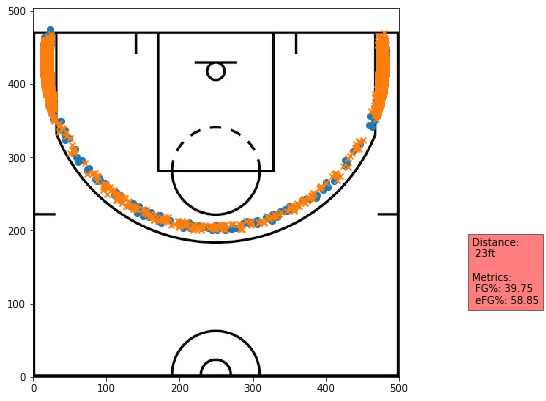

In [49]:
most_effective_shot_league(shots_2019,metric="efg")

## Least effective field goal - player

In [50]:
#export
def least_effective_shot_player(df,player:str,metric:str="efg", exclude:Union[str,List["str"]]="none"):
    distances = ["0ft","1ft","2ft","3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft","29ft","30ft"]
    if type(exclude) == list:
        distances = list(set(distances) - set(exclude))
    max_fg = 101
    max_efg = 101
    final_distance = ""
    for distance in distances:
        player_df = df.loc[(df["shots_by"]==player) & (df["distance"]==distance)]
        fg_pct = _calculate_fg_pct(len(player_df[player_df["outcome"]=="made"]),len(player_df))
        efg_pct = _calculate_efg_pct(len(player_df[player_df["outcome"]=="made"]),len(player_df[(player_df["outcome"]=="made") & (player_df["attempt"]=="3-pointer")]),len(player_df))
        if metric == "fg":
            if fg_pct < max_fg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
        else:
            if efg_pct < max_efg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
    player_df = df.loc[(df["shots_by"]==player) & (df["distance"]==final_distance)]
    plt.figure(figsize=(2*Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    plt.subplot(1, 2, 1)
    plt.title(player+ " shot chart")
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    mades_df = player_df.loc[player_df['outcome']=='made']
    ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys)
    misses_df = player_df.loc[player_df['outcome']=='missed']
    ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys,marker="x")
    ax = plt.subplot(1, 2, 2)
    plt.title(player+ " shot distribution")
    #I would still like to see the whole overall volume
    all_shots = df.loc[(df["shots_by"]==player)]
    distances = all_shots['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
    plt.hist(distances,bins = 30)
    ax.text(35 + 5, 1, "Distance:\n "+ final_distance+"\nMetrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

In [51]:
list_team_players(shots_2019,"Portland")

,shots_by,count
5,Damian Lillard,1063
2,CJ McCollum,944
4,Carmelo Anthony,524
7,Hassan Whiteside,522
0,Anfernee Simons,432
9,Kent Bazemore,322
6,Gary Trent,234
13,Rodney Hood,172
10,Mario Hezonja,155
14,Skal Labissière,147


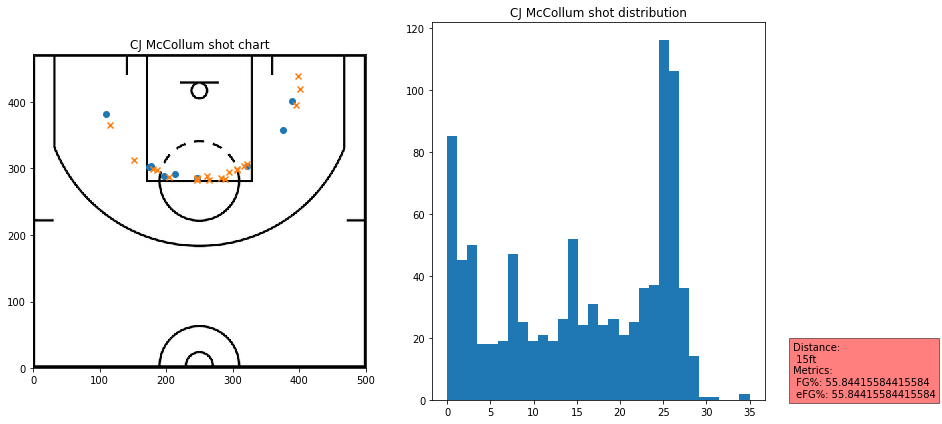

In [52]:
least_effective_shot_player(shots_2019,"CJ McCollum",exclude=["30ft","8ft"])

## Most effective field goal - player

In [57]:
#export
def most_effective_shot_player(df,player:str,metric:str="efg", exclude:Union[str,List["str"]]="none"):
    distances = ["0ft","1ft","2ft","3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft","29ft","30ft"]
    if type(exclude) == list:
        distances = list(set(distances) - set(exclude))
    max_fg = -1
    max_efg = -1
    final_distance = ""
    for distance in distances:
        player_df = df.loc[(df["shots_by"]==player) & (df["distance"]==distance)]
        fg_pct = _calculate_fg_pct(len(player_df[player_df["outcome"]=="made"]),len(player_df))
        efg_pct = _calculate_efg_pct(len(player_df[player_df["outcome"]=="made"]),len(player_df[(player_df["outcome"]=="made") & (player_df["attempt"]=="3-pointer")]),len(player_df))
        if metric == "fg":
            if fg_pct > max_fg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
        else:
            if efg_pct > max_efg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
    player_df = df.loc[(df["shots_by"]==player) & (df["distance"]==final_distance)]
    plt.figure(figsize=(2*Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    plt.subplot(1, 2, 1)
    plt.title(player+ " shot chart")
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
#     plt.text(600, 100, "Distance:\n "+ final_distance+"\n\nMetrics:\n FG%: "+str(round(max_fg,2))+"\n eFG%: "+str(round(max_efg,2)), bbox=dict(facecolor='red', alpha=0.5))
    mades_df = player_df.loc[player_df['outcome']=='made']
    ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys)
    misses_df = player_df.loc[player_df['outcome']=='missed']
    ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys,marker="x")
    ax = plt.subplot(1, 2, 2)
    plt.title(player+ " shot distribution")
    #I would still like to see the whole overall volume
    all_shots = df.loc[(df["shots_by"]==player)]
    distances = all_shots['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
#     plt.hist(distances,max(distances))
    if type(exclude) == list:
        plt.hist(distances,bins = 31 - len(exclude))
        ax.text((31 - len(exclude)) + 15, 1, "Most effective shot: "+str(final_distance)+"\nMetrics:\n FG%: "+str(round(fg_pct,2))+"\n eFG%: "+str(round(efg_pct,2)), bbox=dict(facecolor='red', alpha=0.5))
    else:
        plt.hist(distances,bins = max(distances))
        ax.text(30 + 12, 1, "Most effective shot: "+str(final_distance)+"Metrics:\n FG%: "+str(round(fg_pct,2))+"\n eFG%: "+str(round(efg_pct,2)), bbox=dict(facecolor='red', alpha=0.5))
#     ax.text(35 + 5, 1, "Distance:\n "+ final_distance+"\n\nMetrics:\n FG%: "+str(max_fg)+"\n eFG%: "+str(max_efg), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

In [58]:
list_team_players(shots_2019,"Portland")

,shots_by,count
5,Damian Lillard,1063
2,CJ McCollum,944
4,Carmelo Anthony,524
7,Hassan Whiteside,522
0,Anfernee Simons,432
9,Kent Bazemore,322
6,Gary Trent,234
13,Rodney Hood,172
10,Mario Hezonja,155
14,Skal Labissière,147


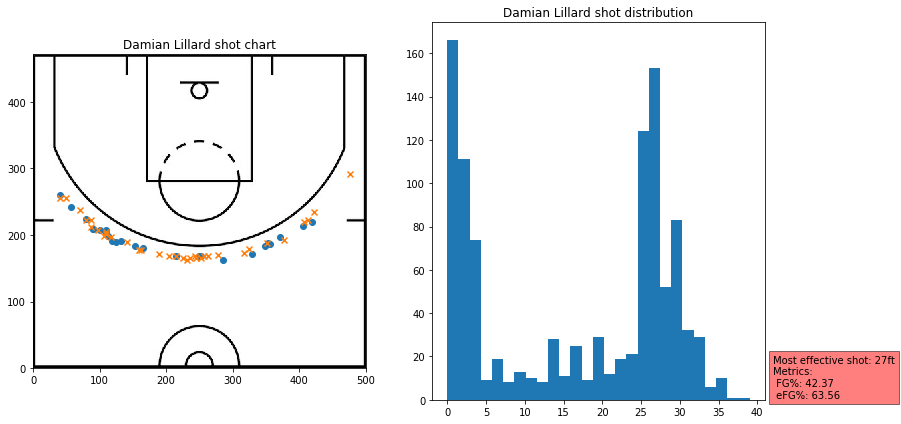

In [59]:
most_effective_shot_player(shots_2019,"Damian Lillard",exclude=["0ft","1ft","17ft","15ft"])

## Export -

In [60]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
